# Business Problem:

- More than 1 million people are hospitalized with pneumonia, which is a very serious problem
- Chest X-rays are currently the best available method for diagnosing it
- Suppose You are working as a Data Scientist at Qure.ai (a Medical startup) and want to Classify if a person has pneumonia or not.
  - You also have to deploy the model on mobile device for real time inferences

  - Please go through this link to know about the existing apps in medical domain :
  
      https://www.grantsformedical.com/apps-for-medical-diagnosis.html

- This was especially useful during the times when COVID-19 was known to cause pneumonia.


<img src='https://drive.google.com/uc?id=1Qc7aF9zBzFz-I6lnhXZK1IOQjwLTfET5' width=400>


   - Image on the left is a normal,
    but on the right we can see severe glass opacity mainly due to air displacement by fluids




## Brief intro:

What is Pneumonia?

- Pneumonia is an infection that inflames the air sacs in one or both lungs.
- The air sacs may fill with fluid or pus (purulent material), causing cough with phlegm or pus, fever, chills, and difficulty breathing.
- A variety of organisms, including bacteria, viruses and fungi, can cause pneumonia.

- Pneumonia can range in seriousness from mild to life-threatening.
- It is most serious for infants and young children, people older than age 65, and people with health problems or weakened immune systems.

<img src='https://drive.google.com/uc?id=1I7HBz2uVPq8SOcjC7el86EZR8kfxy6aK' width=300>

### Agenda & Motivation:

Computer Vision has a lot of applications in medical diagnosis:
- In this lecture we will explain the complete pipeline from loading data to predicting results, and
- It will explain how to build an X-ray image classification model using CNN to predict whether an X-ray scan shows presence of pneumonia.




### Real time constraints:
- Low latency requirements
- False negative or positives can be risky
   - If a person has Pneumonia and your model predicted as Normal
   - If a person is Normal and your model predicted as Pneumonia
- Model should be confident in deciding the class
- Model explainability through visualizations

### **How we are going to solve the problem :**
- In previous classes you have studied about state-of-the-art models like VGG16, ResNet, etc.
- Models like these are computationally heavy and cannot be deployed on mobile devices

### Which model to use here ?

- We are going to introduce mobilenet in this session
    - MobileNet achieves sky high accuracies and is 100x smaller compared to these models
    - MobileNet is used on mobile apps for object detection, image classficiation, etc. and provide low latency outputs for any use case
    

<center><img src='https://drive.google.com/uc?id=10Do0zifY8E3gyyPSZQQsMyiOrzc92FSn' width=700>

MobileNet Architecture</center>

- We will again through the Architecture in detail but before that -
- Lets check our DATA !

In [ ]:
# Importing required libraries

import warnings
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.cm as cm
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

Here we will also see how to utilize TPUs efficiently-

What are TPUs?
  - TPUs are tensor processing units developed by Google to accelerate operations on a Tensorflow Graph.
    - Each TPU packs up to 180 teraflops of floating-point performance and 64 GB of high-bandwidth memory onto a single board.
    - These are Google's custom-developed application-specific integrated circuits (ASICs) used to accelerate machine learning workloads.
  - TPUs were only available on Google cloud but now they are available for free in Colab.

In [ ]:
#tf.distribute.Strategy is a TensorFlow API to distribute training across multiple GPUs,
#multiple machines, or TPUs. Using this API, you can distribute your existing models and
#training code with minimal code changes.
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

Device: grpc://10.52.223.82:8470
Number of replicas: 8



- Below, we define key configuration parameters we'll use in this example.
- To run on TPU, this example must be on Colab with the TPU runtime selected.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# Specifying our training batch size
BATCH_SIZE = 32 * strategy.num_replicas_in_sync

# Specifying the image size
IMAGE_SIZE = [224, 224]

# List containing class names, which will be used to index on our model output
# 0 = NORMAL, 1 = PNEUMONIA
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

tf.data.AUTOTUNE
- tf.data builds a performance model of the input pipeline
- runs an optimization algorithm to find a good allocation of its CPU budget across all parameters specified as **AUTOTUNE**.
- While the input pipeline is running, tf.data tracks time spent in each operation, so that these times can be fed to the optimization algorithm.

## Load the data:

- The Chest X-ray data we are using from
[*Cell*](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5) divides the data into
training and test files.
- Here we are downloading the data using Google Cloud link

   



###Download dataset using google cloud link:

Here the dataset is present in the TFRecord file format format:

What is TFRecord file format format ?
- A TFRecord file stores your data as a sequence of binary strings.
- It is Tensorflow’s own binary storage format.
- Advantages of tf.record format :
    - Binary data takes up less space on disk,
    - takes less time to copy
    - can be read much more efficiently from disk.
    - If you are working with large datasets, using a binary file format for storage of your data can have a significant impact on the performance of your import pipeline


In [ ]:
train_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec"
)
train_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/paths.tfrec"
)

ds = tf.data.Dataset.zip((train_images, train_paths))

In [ ]:
COUNT_NORMAL = len([filename for filename in train_paths if "NORMAL" in filename.numpy().decode("utf-8")])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_paths if "PNEUMONIA" in filename.numpy().decode("utf-8")])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

print('Total Count of images:', COUNT_NORMAL+COUNT_PNEUMONIA )

Normal images count in training set: 1349
Pneumonia images count in training set: 3883
Total Count of images: 5232


- Notice that there are way more images that are classified as pneumonia than normal.
- This shows that we have an **imbalance** in our data i.e our model can be biased towards high majority class (Pneumonia in our case)

### **How we are going to solve the class imbalance here ?**

#### Can we apply augmentation here ?

- Here Data augmentation will not be useful because X-ray scans are only taken in a specific orientation, and variations such as flips and rotations will not exist in real X-ray images.

- We will correct for this imbalance later using class weights

In [ ]:
TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.

weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT)  / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


- The weight for class 0 (Normal) is a lot higher than the weight for class 1 (Pneumonia).
- Because there are less normal images, each normal image will be weighted more to balance the data as the CNN works best when the training data is balanced.

### Creating (Image, Label) pair :

- We want to map each filename to the corresponding (image, label) pair. The following methods will help us do that.

- As we only have two labels, we will encode the label so that `1` or `True` indicates pneumonia and `0` or `False` indicates normal.

In [ ]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, "/")
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size.
    return tf.image.resize(img, IMAGE_SIZE)


def process_path(image, path):
    label = get_label(path)
    # load the raw data from the file as a string
    img = decode_img(image)
    return img, label


ds = ds.map(process_path, num_parallel_calls = AUTOTUNE)

Let's split the data into a training and validation datasets.

In [ ]:
ds = ds.shuffle(10000)
train_ds = ds.take(4300)
val_ds = ds.skip(4300)

Let's visualize the shape of an (image, label) pair.

In [ ]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)

Image shape:  (224, 224, 3)


Load and format the test data as well.

In [ ]:
test_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec"
)
test_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/paths.tfrec"
)

COUNT_NORMAL = len([filename for filename in test_paths if "NORMAL" in filename.numpy().decode("utf-8")])
print("Normal images count in test set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in test_paths if "PNEUMONIA" in filename.numpy().decode("utf-8")])
print("Pneumonia images count in test set: " + str(COUNT_PNEUMONIA))

Normal images count in test set: 234
Pneumonia images count in test set: 390


In [ ]:
test_ds = tf.data.Dataset.zip((test_images, test_paths))

test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds_batch = test_ds.batch(BATCH_SIZE)

## Visualize the dataset

- First, let's use buffered prefetching so we can yield data from disk without having I/O
become blocking.

- Please note that large image datasets should not be cached in memory.
- We do it here because the dataset is not very large and we want to train on TPU.

In [ ]:
def prepare_for_training(ds, cache=True):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.

    ds = ds.cache()
    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

Call the next batch iteration of the training data.

In [ ]:
train_ds_batch = prepare_for_training(train_ds)
val_ds_batch = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds_batch))

Define the method to show the images in the batch.

In [ ]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255)
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

As the method takes in NumPy arrays as its parameters, call the numpy function on the
batches to return the tensor in NumPy array form.

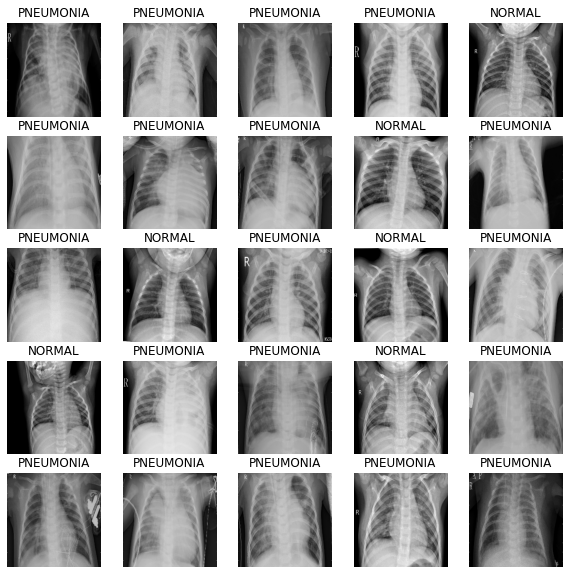

In [ ]:
show_batch(image_batch.numpy(), label_batch.numpy())

**Question:**

    Why didn't we apply augmentation to our data before training ?

    A) Augmentation increases computational cost for our mobilenet
    B) Augmentation decreases mobilenet accuracy as it has less parameters
    C) Xray images becomes useless after augmentation
    D) MobileNet does not accept augmented images





**Answer:**

C)

- Here Data augmentation will not be useful because X-ray scans are only taken in a specific orientation
- variations such as flips and rotations will not exist in real X-ray images.



## MobileNet: Why and How ?
Now that our dataset is ready !

We move on to building and training our model.

- While working with Image datasets, some state-of-the-art models include ResNet50, InceptionNet, VGG16, AlexNet, etc.
- These model architectures do achieve groundbreaking accuracies on ImageNet Dataset but are computationally heavy to train and perform model inference
- This called for need of a lightweight model but reliable model
- MobileNet, introduced in 2017 as a lightweight deep neural network, MobileNet has fewer parameters and high accuracy

   - Original Paper: https://arxiv.org/abs/1704.04861

### Using MobileNet:


| Model Name | Number of params | Top 1 Acc | Top 5 Acc |
| --- | --- | --- | --- |
| MobileNet | 2.3M | 71.0| 90.5
| ResNet50 | 25.6M | 76 | 93
| Inception | 11.2M | 74.8 |92.2
| VGG16 | 138M | 74.4 | 91.9
| AlexNet | 62M | 63.3 | 84.6

- We need to design networks with low parameters, MobileNet is one such model
- Before jumping into details, Lets compare metric of ResNet50 and MobileNet
- MobileNet has 90.5 top 5 acc which is still good, given the fact that it has only 2.5 M parameters
- MobileNet is majorily used for on-device mobile inference, running on Tensorflow Lite (TFlite): https://www.tensorflow.org/lite/guide
- TFlite is a subset of TF, having only necessary functions so we can install the package on low resource devices

#### Where is MobileNet used ?

- MobileNet, being an efficient yet reliable deep learning network is being used in Mobile apps
- On-device Computer vision for mobile devices to perform object detection, image classfication, etc.
- Low-latency inference allows for quick inference
- MobileNet can be easily integrated for medical use in nobile apps, to give precise results on, assume a xray test for pneumonia
- We will learn how to train a MobileNet Model on pneumonia chest xray data which can be deployed in a mobile app

<center>  <img src='https://drive.google.com/uc?id=1rATKQs9lRJcYARSk53N1uw-7RX8G8nNB' width=700></center>

#### **MobileNet : Behind the Scenes**

MobileNet core is backed by Depthwise and Pointwise Convolutions which are computationally efficient yet produce significant results.</br>

#### How? Lets find out
- MobileNet has aprox 30 layers and ResNet50 also has 50 layers
- So how did mobilenet have 10x low parameters?
- Mobilenet does not use normal convolutional layers
- They use something called Depthwise & pointwise  convolutions which is very compute inexpensive
- If the image has 3 input channels, then running a single kernel
- across this image results in an output image with only 1 channel per pixel.

<img src='https://drive.google.com/uc?id=1rXhzhqbAxPEAcZ8vB5EexJ0AGG-Zq19h' height=250>


- So for each input pixel, no matter how many channels it has
- the convolution writes a new output pixel with only a single channel

- MobileNet only uses these standard conv layer once, the first conv layers
- after that all other layers do “depthwise separable” convolution
- which is a combination of
 1. depthwise convolution
 2. pointwise convolution

**Depthwise Convolution** is a type of convolution where we apply a single convolutional filter/kernel for each input channel in the image (3 in RGB). </br>In the regular 2D convolution performed over multiple input channels, the filter is as deep as the input and lets us freely mix channels to generate each element in the output.

In contrast, depthwise convolutions keep each channel separate. To summarize the steps, we:


- For MobileNets the depthwise convolution applies a single filter to each input channel.
- The pointwise convolution then applies a 1×1 convolution to combine the
outputs the depthwise convolution.
- A standard convolution
both filters and combines inputs into a new set of outputs
in one step.
- The depthwise separable convolution splits this
into two layers, a separate layer for filtering and a separate
layer for combining.
- This factorization has the effect of
drastically reducing computation and model size.

Summary:
- Split the input and filter into channels.
- We convolve each input with the respective filter.
- We stack the convolved outputs together.

<img src='https://drive.google.com/uc?id=1HqRUAtpzOMa7TY5DAeaKEmvmlen7uN02' height=250>


- Unlike a regular convolution it does not combine the input channels
-  but it performs convolution on each channel separately.
- For an **input image with 3 channels**,a depthwise convolution creates an **output image that also has 3 channels**.
- Each channel gets its own set of weights.
- The purpose of the depthwise convolution is to filter the input channels

<img src=https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/047/001/original/Screenshot_2023-09-08_at_12.21.18_PM.png?1694156086 width=800 height=500>

**Pointwise Convolution** is a type of convolution that uses a 1x1 kernel: a kernel that iterates through every single point. This kernel has a depth of however many channels the input image has.
- It is just a conv with 1x1 kernel, this simply adds up all the channels (as a weighted sum)
- we usually stack together many of these pointwise kernels to create an output image with many channels.
- The purpose of this pointwise convolution is to
- combine the output channels of the depthwise convolution to create new features.


<img src='https://drive.google.com/uc?id=1S_8kSlQz7IXybIGzw496Jo4BBGOcvCoZ' height=250>

- When we put these two things together a depthwise convolution followed by a pointwise convolution
- the result is called a depthwise separable convolution.
- A regular convolution does both filtering and combining in a single go,
- but with a depthwise separable convolution these two operations are done as separate steps

<img src='https://drive.google.com/uc?id=1CbhdIjO-y6kxwzAug9MspkylJEsTuOds' height=450>

#### **How do Depthwise & pointwise convolutions helps?**
- The end results of both (Normal & MobileNet ) approaches are pretty similar they both filter the data and make new features
- but a regular convolution has to do much more computational work to get there and needs to learn more weights.
- By this we are able to lower down the # of params & FLOPs


<img src='https://drive.google.com/uc?id=1qopmqUg464rhd4M2RbqSMtHMA0cqDrMJ' height=450>



- Now lets look at the whole network

#### MobileNets architecture

<img src='https://drive.google.com/uc?id=1e6o18Z0PAf_7Q_Zc1TzAC_g89VDCzSGm' height=450>

- The MobileNets network has approx 30 layers.
- The design of the network is quite straightforward:
 1. convolutional layer with stride 2
 2. depthwise layer
 3. pointwise layer that doubles the number of channels
 4. depthwise layer with stride 2
 5. pointwise layer that doubles the number of channels
 6. depthwise layer
 7. pointwise layer
 8. depthwise layer with stride 2
 9. pointwise layer that doubles the number of channels

- then reapeat this structure 5 times

### MobileNet versions:

We primarily have three versions of MobileNet, which over the years improved on-device machine learning for Mobile devices.

Refer to this [First MobileNet paper](https://arxiv.org/pdf/1704.04861.pdf)

#### **MobileNetV1**
The first version of MobileNet was introduced in 2017 by Google. The idea behind it was primarily develop TensorFlow based comoputer vision models that are suitable for low-resource on device inference on mobile devices.

The core architecture of MobileNet V1 is based on depthwise and pointwise convolutions that helps in reducing the computational of the model.

<img src='https://drive.google.com/uc?id=1gEJpk0XE9VF8T-bD-OkCIwV1tx42abmB' width=300>
<br>
<br>

#### **MobileNetV2**[POST READ]
The second version of MobileNet architecture was released in 2018, a ramped up version of V1, to optimize the model architecture for object detection, classfication and segmentation tasks.

The architecture introduced Linear bottlenecks (a BottleNeck Block without the last activation) and residual connections (known as shortcuts) which enable higher accuracy and faster training.

[MobileNetV2 Paper](https://arxiv.org/pdf/1801.04381.pdf)

<img src='https://drive.google.com/uc?id=1QhUZ9Yjqn1uCyjyO5BGqFmO_DHMjggKr' width=300>
<br>
<br>





### Architecture using keras or tf:

- MobileNet is one of the smallest Deep Neural networks that are fast and efficient and can be run on devices without high-end GPUs.
- Implementation of these networks is very simple when using a framework such as Keras (on TensorFlow).

In [ ]:
import tensorflow as tf

#import all necessary layers
from tensorflow.keras.layers import Input, DepthwiseConv2D
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.layers import ReLU, AvgPool2D, Flatten, Dense

from tensorflow.keras import Model

In [ ]:
# MobileNet block
def mobilnet_block (x, filters, strides):

    x = DepthwiseConv2D(kernel_size = 3, strides = strides, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters = filters, kernel_size = 1, strides = 1)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    return x

In [ ]:
#stem of the model
input = Input(shape = (224, 224, 3))
x = Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same')(input)
x = BatchNormalization()(x)
x = ReLU()(x)

In [ ]:
# main part of the model
x = mobilnet_block(x, filters = 64, strides = 1)
x = mobilnet_block(x, filters = 128, strides = 2)
x = mobilnet_block(x, filters = 128, strides = 1)
x = mobilnet_block(x, filters = 256, strides = 2)
x = mobilnet_block(x, filters = 256, strides = 1)
x = mobilnet_block(x, filters = 512, strides = 2)
for _ in range (5):
     x = mobilnet_block(x, filters = 512, strides = 1)
x = mobilnet_block(x, filters = 1024, strides = 2)
x = mobilnet_block(x, filters = 1024, strides = 1)
x = AvgPool2D (pool_size = 7, strides = 1, data_format='channels_first')(x)
output = Dense (units = 1000, activation = 'softmax')(x)
model = Model(inputs=input, outputs=output)
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_28 (Conv2D)          (None, 112, 112, 32)      896       
                                                                 
 batch_normalization_54 (Bat  (None, 112, 112, 32)     128       
 chNormalization)                                                
                                                                 
 re_lu_54 (ReLU)             (None, 112, 112, 32)      0         
                                                                 
 depthwise_conv2d_26 (Depthw  (None, 112, 112, 32)     320       
 iseConv2D)                                                      
                                                                 
 batch_normalization_55 (Bat  (None, 112, 112, 32)     128

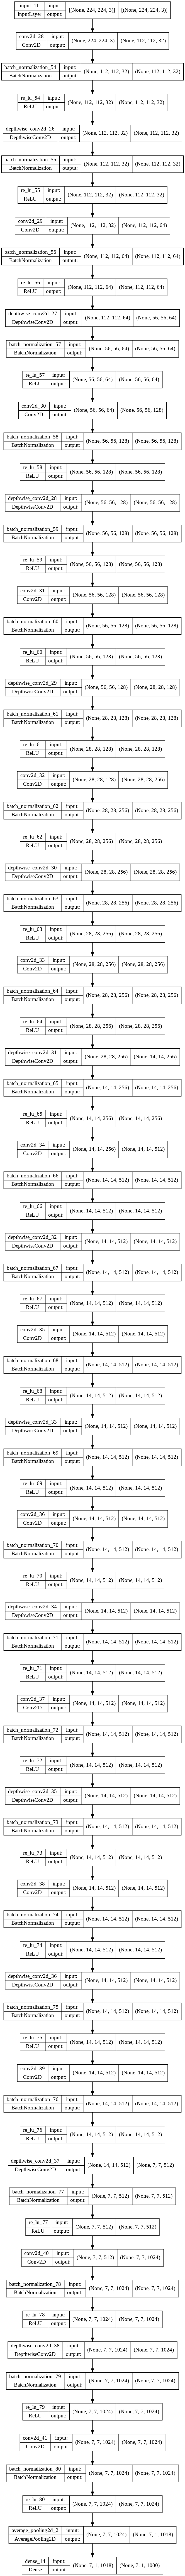

In [ ]:
#plot the model
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_dtype=False,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

## Fine Tuning for pneumonia xray images:

Now that we understand, how a MobileNet works, lets use the Mobilenet with pretrained weights on ImageNet dataset.

- Basic transfer learning gets us only so far.
  - We usually add only two to three fully connected layers after the generic layers to make the new classifier model.
-  But if our task is identifying penumonia or different bones in an X-ray image and we want to start out from an ImageNet trained network, the high dissimilarity between regular ImageNet images and X-ray images
- So if you have large amount of data and want higher accuracy, we must allow more layers to be trained.
-  This means unfreezing some of the layers that would have otherwise been frozen in transfer learning. This is known as fine tuning. Figure shows an example where some convolutional layers near the head/top are unfrozen and trained for the task at hand.

<img src=https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/047/002/original/Screenshot_2023-09-08_at_12.22.04_PM.png?1694156124 width=800>

- We often hear data scientists saying, “I fine tuned the model,” which means that they took a pretrained model, removed task-specific layers and added new ones, froze the lower layers,
- and trained the upper part of the network on the new dataset they had.
>**NOTE:**<br>
> In daily lingo, transfer learning and fine tuning are used interchangeably. When spoken, transfer learning is used more as a general concept, whereas fine tuning is referred to as its implementation.


- But in our case since our dataset is small so performing finetuning will increase the number of parameters to train and result in overfitting.


- Lets see how to finetune using Mobilenet:


In [ ]:
def build_model():

    mobilenet_model = tf.keras.applications.MobileNetV2(
        weights ='imagenet',
        include_top = False,
        input_shape = (224,224,3)
    )

    #Freezing the pretrained mobilenet layers except the last  layer
    # Known as fintuning the model

    for layer in mobilenet_model.layers[:-2]:
        layer.trainable = False


    # for layer in mobilenet_model.layers:
    #     layer.trainable = False


    #Output of base model
    x = mobilenet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation = "relu")(x)
    output = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
    pretrained_model = tf.keras.Model(inputs = mobilenet_model.input, outputs = output)

    return pretrained_model

In [ ]:
finetuned_mobilenet = build_model()

In [ ]:
# Visualizing our model layers and parameters
finetuned_mobilenet.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_12[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                          

### Defining callbacks

- The checkpoint callback saves the best weights of the model, so next time we want to use the model,
- we do not have to spend time training it.
-The early stopping callback stops
the training process when the model starts becoming stagnant, or even worse, when the
model starts overfitting.

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive/',force_remount=True)

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=3, restore_best_weights=True
)

We also want to tune our learning rate.
  - Too high of a learning rate will cause the model
to diverge.
  - Too small of a learning rate will cause the model to be too slow. We
implement the exponential learning rate scheduling method below.

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [ ]:
initial_learning_rate = 0.01

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

### Training the model:

In [ ]:
with strategy.scope():
  finetuned_mobilenet = build_model()
  METRICS = [
  tf.keras.metrics.BinaryAccuracy(),
  tf.keras.metrics.Precision(name="precision"),
  tf.keras.metrics.Recall(name="recall"),
  ]
  finetuned_mobilenet.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss="binary_crossentropy",
  metrics=METRICS,
  )

  history = finetuned_mobilenet.fit(
  train_ds_batch,
  epochs = 10,
  validation_data = val_ds_batch,
  class_weight = class_weight,
  callbacks=[checkpoint_cb,early_stopping_cb,lr_scheduler]
  )

Epoch 1/10
17/17 [==============================] - 46s 2s/step - loss: 1.0123 - binary_accuracy: 0.7840 - precision: 0.9262 - recall: 0.7681 - val_loss: 0.2306 - val_binary_accuracy: 0.9024 - val_precision: 0.8999 - val_recall: 0.9785 - lr: 0.0100
Epoch 2/10
17/17 [==============================] - 3s 153ms/step - loss: 0.2799 - binary_accuracy: 0.8923 - precision: 0.9618 - recall: 0.8892 - val_loss: 0.2771 - val_binary_accuracy: 0.8412 - val_precision: 0.8274 - val_recall: 0.9957 - lr: 0.0089
Epoch 3/10
17/17 [==============================] - 4s 227ms/step - loss: 0.2120 - binary_accuracy: 0.9065 - precision: 0.9782 - recall: 0.8930 - val_loss: 0.2991 - val_binary_accuracy: 0.8176 - val_precision: 0.8056 - val_recall: 0.9971 - lr: 0.0079
Epoch 4/10
17/17 [==============================] - 6s 393ms/step - loss: 0.1902 - binary_accuracy: 0.9181 - precision: 0.9815 - recall: 0.9060 - val_loss: 0.3540 - val_binary_accuracy: 0.8026 - val_precision: 0.7920 - val_recall: 0.9986 - lr: 0.007

## Plotting model performance

Let's plot the model accuracy and loss for the training and the validating set. Note that
no random seed is specified for this notebook. For your notebook, there might be slight
variance.

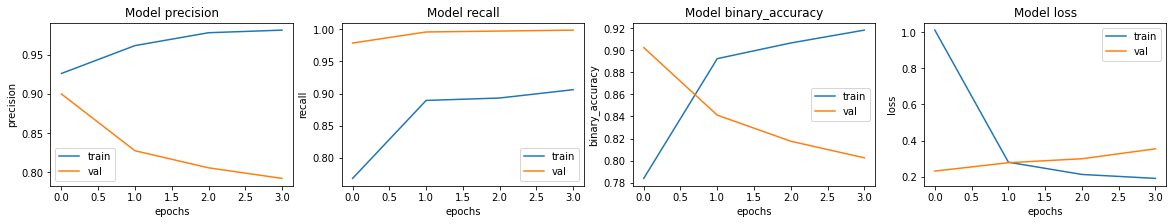

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "binary_accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

### Loading the Model



In [ ]:
loaded_mobilenet = tf.keras.models.load_model('xray_model.h5')

## Evaluate model

Let's evaluate the model on our test data!

In [ ]:
loaded_mobilenet.evaluate(test_ds_batch, return_dict=True)

3/3 [==============================] - 3s 437ms/step - loss: 0.6547 - binary_accuracy: 0.6939 - precision: 0.6749 - recall: 0.9846


{'loss': 0.6546863913536072,
 'binary_accuracy': 0.6939102411270142,
 'precision': 0.6748681664466858,
 'recall': 0.9846153855323792}

- We see that our accuracy on our test data is 69%, which is lower than the accuracy for our validating set. This may indicate overfitting.
### Try **finetuning the model** further to decrease overfitting to the training and validation sets.
- [Refer lecture 2 to deal with overfitting.]

- Our recall is greater than our precision, indicating that almost all pneumonia images are correctly identified but some normal images are falsely identified.
- We should aim to increase our precision.
   - link to refer for solutions:<br>
    1. https://stats.stackexchange.com/questions/134599/how-to-classify-a-unbalanced-dataset-by-convolutional-neural-networks-cnn
    2. https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

Predicting on a test image using our trained MobileNet Model

This image is 34.41 percent NORMAL
This image is 65.59 percent PNEUMONIA
CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 10.5 µs


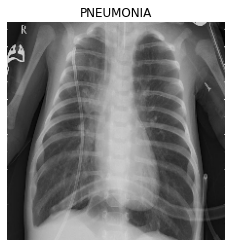

In [ ]:
for image, label in test_ds_batch.take(2):
      plt.imshow(image[2] / 255.0)
      plt.title(CLASS_NAMES[label[2].numpy()])
      plt.axis('off')
prediction = finetuned_mobilenet.predict(test_ds_batch.take(2))[2]
scores = [1 - prediction, prediction]
for score, name in zip(scores, CLASS_NAMES):
    print("This image is %.2f percent %s" % ((100 * score), name))
%time

## Confusion Matrix

In [ ]:
label_list = []
prediction_list = []

for image, label in test_ds:
    image = tf.expand_dims(image, axis = 0)
    prediction = finetuned_mobilenet.predict(image)
    label = tf.where(label, 1, 0)

    if prediction > 0.5 :
        prediction = 1
    else :
        prediction = 0

    prediction_list.append(prediction)
    label_list.append(label)

In [ ]:
test_confusion_matrix = tf.math.confusion_matrix(label_list, prediction_list)

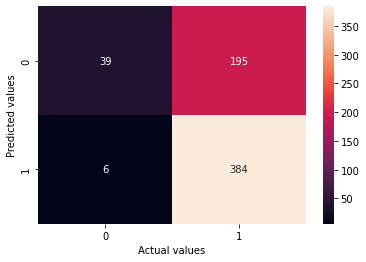

In [ ]:
ax = sns.heatmap(test_confusion_matrix, annot = True, fmt ='g')
ax.set(xlabel = 'Predicted values', ylabel = 'Actual values')

plt.show()

## Can we figure out which part of the image our model focuses on to get a prediction ?

* We, **as humans**, when we try to classify an image.
* **we look at certain region in the image to make our judgement**.
* **For eg:** In case of cats & dog classification, we’ll focus on face of the animal in the picture.
* In this case, i.e. pneunomnia classification, **the domain expert or doctor look at the specific region of the xray in the frame**.

**How can we check what region in the image our CNN is focusing on ?**

* With the help of **GradCAM(Gradient-weighted Class Activation Map**) algorithm.
* It helps to find out the region on which **CNN is focusing on to predict particular class**.

# GRADCAM (Post Read)


* GradCAM is an **improvement** over **CAM** in `versatility and accuracy`.
* It is complex but, luckily, **the output is intuitive**.
* **STEPS OF GRADCAM ALGO:**
    1. Take an **image** as input  
    2. **Create a model** that is `cut off at the layer for which we want to create a GRAD-CAM heat-map`.
    3. We attach the **fully-connected layers** for `prediction`.
    4. We then run the input through the model, **grab the layer output, and loss**.
    5. Next, we find the **gradient of the output of our desired model layer w.r.t. the model loss**.
    6.  From there, `we take sections of the gradient which contribute to the prediction`, reduce, resize, and rescale so that the heat-map can be overlaid with the original image.

<img src='https://drive.google.com/uc?id=1Ud2FlTlFuaKv0Yla_nIly2AdXXfTloB9' height=350>

Since we need the last Convolution layer for implementing our GRADCAM Algorithm, </br>
we print every Conv. layer name in our pretrained_modbilenet model

In [ ]:
for i in range(len(finetuned_mobilenet.layers)):
    layer = finetuned_mobilenet.layers[i]
    if 'conv' not in layer.name:
        continue
    print(i , layer.name , layer.output.shape)

4 expanded_conv_depthwise (None, 112, 112, 32)
5 expanded_conv_depthwise_BN (None, 112, 112, 32)
6 expanded_conv_depthwise_relu (None, 112, 112, 32)
7 expanded_conv_project (None, 112, 112, 16)
8 expanded_conv_project_BN (None, 112, 112, 16)


Last convolutional layer for GRADCAM is expanded_conv_project_BN

In [ ]:
last_conv_layer_name = finetuned_mobilenet.layers[8].name
last_conv_layer_name

'expanded_conv_project_BN'

In [ ]:
!pip install tf-explain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


This image is 34.41 percent NORMAL
This image is 65.59 percent PNEUMONIA


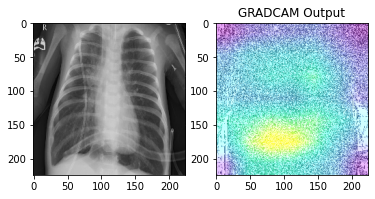

In [ ]:
from tf_explain.core.grad_cam import GradCAM
import random

for image, label in test_ds_batch.take(2):

    data = ([image[2].numpy()], None)
    # print('Original label',CLASS_NAMES[label[2].numpy()])
    image = image[2] / 255

prediction = finetuned_mobilenet.predict(test_ds_batch.take(2))[2]
scores = [1 - prediction, prediction]

for score, name in zip(scores, CLASS_NAMES):
    print("This image is %.2f percent %s" % ((100 * score), name))

# Start explainer
explainer = GradCAM()
grid = explainer.explain(data, finetuned_mobilenet,class_index = 0)

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, 2)

axarr[0].imshow(image)
axarr[1].imshow(grid)
# axarr[0].title.set_text(f"{float(prediction)*100:.2f}% penumonia predicted")
axarr[1].title.set_text('GRADCAM Output')
plt.show()

**Question** :

    What is GRADCAM ?

    A) Colourises our black and white images
    B) Plots the part of input where model focuses
    C) Is used for xray images specifically
    D) Used for model evaluation

**Answer** :

B)

GRADCAM :
- Gradient-weighted Class Activation Mapping (Grad-CAM)
- Used to visualize which part of our input the model focuses while prediction
- Makes a heatmap around the focused area(s)
- uses the gradients of any target image flowing into the final convolutional layer to produce a heatmap highlighting the important regions in the image



## Rethinking Model Design (Width, Depth, Resolution):

Now that we have studied about MobileNet and its working lets scale things up.
- Generally, when we design an architecture, we think in three dimensions
 - Width Scaling : Increasing number of features in conv layers
 - Depth Scaling : Increasing number of layers
 - Resolution Scaling : Adjusting Input shape
-  ResNet / MobileNet optimizes one dimension at a time
- Couldn’t we search for the ideal combination of all three dimsion at once
- Just like we perform hyperparameter tuning in desion tree, chosing tree depth, min_samples_leaf, min_samples_split, etc?
- a brute-force search through the entire set of possible operations would be a very large a task.
- Next model (EfficientNet) has simplified the problem in a clever way.

<img src='https://drive.google.com/uc?id=1q_VMgiclluHah8Jj1toXf5x_CsDEpIKf' height=450>

### Intro to EfficientNet

- Original Paper: https://arxiv.org/abs/1905.11946

- **EfficientNet** is actually a family of neural networks of different sizes, where a lot of attention was paid to the scaling of the networks in the family.
- Convolutional archi‐ tectures have three main ways of scaling:
    - Use more layers.
    - Use more channels in each layer.
    - Use higher-resolution input images.
- The EfficientNet paper points out that these three scaling axes are not independent:
   - “If the input image is bigger, then the network needs more layers to increase the receptive field and more channels to capture more fine-grained patterns on the bigger image.”
- The novelty in the EfficientNetB0 through EfficientNetB7 family of neural networks is that they are scaled along all three scaling axes rather than just one, as was the case in earlier architecture families such as ResNet50/ResNet101/ResNet152.
- The Effi‐ cientNet family is today the workhorse of many applied machine learning teams because it offers optimal performance levels for every weight count.


<img src='https://drive.google.com/uc?id=1_hwsdXsohGH6UDtR4ZMuhH1UDOum2MR4' height=450>





- EfficientNet models generally use an order of magnitude fewer parameters and FLOPS than other ConvNets with
similar accuracy

<img src=https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/046/999/original/Screenshot_2023-09-08_at_12.22.45_PM.png?1694155997 width=800>

- They Came up with eights models B0 to B7 (with increasing size)
- For example, **EfficientNet-B3 achieves higher accuracy than ResNet101 using 18x fewer FLOPS.**

- Full efficientnet code from scracth: https://github.com/qubvel/efficientnet/blob/f7f3e736c113b872caf53dae9fbbda996a8eb87d/efficientnet/model.py


<img src='https://www.researchgate.net/profile/Tashin-Ahmed/publication/344410350/figure/fig4/AS:1022373302128641@1620764198841/Architecture-of-EfficientNet-B0-with-MBConv-as-Basic-building-blocks.png'>

### Loading pretrained efficientnet:
https://keras.io/api/applications/efficientnet/

In [ ]:
with strategy.scope():
    pretrained_model = tf.keras.applications.EfficientNetB6(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
    pretrained_model.trainable = True # fine-tuning

    model = tf.keras.Sequential([
        # convert image format from int [0,255] to the format expected by this model
        tf.keras.layers.Lambda(lambda data: tf.keras.applications.efficientnet.preprocess_input(tf.cast(data, tf.float32)), input_shape=[*IMAGE_SIZE, 3]),
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(2, activation='softmax')
    ])

## Beyond Convolution: The Transformer Architecture:[Optional to read]

- The architectures for computer vision that are discussed till now all rely on convolutional filters.
- Compared to the naive dense neural networks discussed in lecture 1, convolutional filters reduce the number of weights necessary to learn how to extract information from images.
- However, as dataset sizes keep increasing, there comes a point where this weight reduction is no longer necessary.
- Ashish Vaswani et al. proposed the Transformer architecture for natural language processing in a 2017 paper with the catchy title **“Attention Is All You Need.”**
- As the title indicates, the key innovation in the Transformer architecture is the concept of attention—having the model focus on some part of the input text sequence when pre‐ dicting each word.
- For example, consider a model that needs to translate the French phrase “ma chemise rouge” into English (“my red shirt”).
  - The model would learn to focus on the word rouge when predicting the second word of the English translation, red.   
- The Transformer model achieves this by using positional encodings.
- Instead of simply representing the input phrase by its words, it adds the position of each word as an input: (ma, 1), (chemise, 2), (rouge, 3).
- The model then learns from the training dataset which word of the input it needs to focus on when predicting a specific word of the output.


- **The Vision Transformer (ViT) model** adapts the Transformer idea to work on images.
- The equivalent of words in images are square patches, so the first step is to take the input image and break it into patches,

In [ ]:
patches = tf.image.extract_patches(
        images=images,
        sizes=[1, self.patch_size, self.patch_size, 1],
        strides=[1, self.patch_size, self.patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
)

<img src=https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/047/000/original/Screenshot_2023-09-08_at_12.23.45_PM.png?1694156046 width=800>

- Here if you observed The input image is broken into patches that are treated as the sequence input to the Transformer.
- The patches are represented by concatenating the patch pixel values and the patch position within the image:
   

In [ ]:
encoded = (tf.keras.layers.Dense(...)(patch) +
               tf.keras.layers.Embedding(...)(position))

- Note that the patch position is the ordinal number (5th, 6th, etc.) of the patch and is treated as a categorical variable.
- A learnable embedding is employed to capture close‐ ness relationships between patches that have related content.
- The patch representation is passed through multiple transformer blocks, each of which consists of an attention head (to learn which parts of the input to focus on)

In [ ]:

x1 = tf.keras.layers.LayerNormalization()(encoded)
#Just for sake of basic overview
attention_output = tf.keras.layers.MultiHeadAttention(
    num_heads=num_heads, key_dim=projection_dim, dropout=0.1
)(x1, x1)

The attention output is used to add emphasis to the patch representation:

In [ ]:

# Skip connection 1.
x2 = tf.keras.layers.Add()([attention_output, encoded])
x3 = tf.keras.layers.LayerNormalization()(x2)# Layer normalization 2.



and passed through a set of dense layers:

In [ ]:

# multilayer perceptron (mlp), a set of dense layers.
x3 = mlp(x3, hidden_units=transformer_units,
          dropout_rate=0.1)
# Skip connection 2 forms input to next block
encoded = tf.keras.layers.Add()([x3, x2])

- The training loop is similar to that of any of the convolutional network architectures as we discussed.
- Note that the ViT architecture requires a lot more data than convolutional network models—the authors suggest pretraining the ViT model on large amounts of data and then fine-tuning on smaller datasets.
- Even though not particularly promising at present for our relatively small dataset, the idea of applying the Transformer architecture to images is interesting, and a potential source of new innovations in computer vision.

## We will discuss about transformers and attention in lot more details in NLP module.

##Summary of pretrained models:



| Model Name | Number of params | Top 1 Acc | Top 5 Acc |
| --- | --- | --- | --- |
| EfficientnetB0 | 5.3M | 77.3 | 93.5
| MobileNet | 2.3M | 71.0| 90.5
| ResNet50 | 25.6M | 76 | 93
| Inception | 11.2M | 74.8 |92.2
| VGG16 | 138M | 74.4 | 91.9
| AlexNet | 62M | 63.3 | 84.6



### How do you decide which model you should chose on a new dataset?

- If you want to roll your own layers, start with VggNet. It’s the simplest model that will perform well.
- For edge devices, you typically want to optimize for models that can be downloaded fast, occupy very little space on the device, and don’t incur high latencies during prediction. For a small model that runs fast on low-power devices, con‐ sider MobileNetV2.
- If you don’t have size/speed restrictions (such as if inference will be done on autoscaling cloud systems) and want the best/fanciest model, consider Efficient‐ Net.
- If you belong to a conservative organization that wants to stick with something tried and true, choose ResNet50 or one of its larger variants.
-if training cost and prediction latency are not of concern, or if small improvements in model accuracy bring outside rewards, consider an ensemble of three complementary models.




### Points to remember before applying transfer learning:


  




- Mainly there are two factors
1. size of the new dataset (small or big), and
2. its similarity to the original dataset (e.g. ImageNet-like in terms of the content of images and the classes, or very different)

- New dataset is small and similar to original dataset.
 - Since the data is small, it is not a good idea to fine-tune the ConvNet due to overfitting concerns.  
 - data is similar to the original data, we expect higher-level features in the ConvNet to be relevant to this dataset as well.

- New dataset is large and similar to the original dataset.
 - Since we have more data, we can have more confidence that we won’t overfit if we were to try to fine-tune through the full network.
- New dataset is large and very different from the original dataset.
 -  Since the dataset is very large, we may expect that we can afford to train a ConvNet from scratch.
 - However, in practice it is very often still beneficial to initialize with weights from a pretrained model.

# Supplementary material

Other models to follow :-
#### DenseNet : https://arxiv.org/pdf/1608.06993.pdf

#### SqueezeNet : https://arxiv.org/pdf/1602.07360.pdf

#### NASNet : https://arxiv.org/pdf/1707.07012.pdf